## Optimization II - Project 2

### Anjali Pillai (ap66745), Sarah Stephens (sgs2623), Tara Mary Joseph (tj9763), Téa McCormack (tsm2423)


## 1) checking the base case

In [4]:
import numpy as np
import scipy.stats as stats
import pandas as pd

# Constants
DAYS = 365
COACH_SEATS = 100
FIRST_CLASS_SEATS = 20
OVERBOOK_LIMIT = 5  # Start with overselling by 5 in coach

# Pricing and demand probabilities
coach_prices = [300, 350]
coach_probs = [0.65, 0.30]

first_class_prices = [425, 500]
first_class_probs = [0.08, 0.04]

# Show-up probabilities
coach_show_prob = 0.95
first_class_show_prob = 0.97

# Overbooking costs
bump_to_first_class_cost = 50
bump_off_cost = 425

# Discounting
discount_rate = 0.17
daily_discount = 1 / (1 + discount_rate / 365)

# DP table: (days_remaining, coach_tickets_sold, first_class_tickets_sold) -> expected_profit
dp = {}

def optimized_overbooking_cost(coach_sold, first_class_sold):
    expected_cost = 0

    # Compute ranges within 3 std deviations for binomial distributions
    coach_mean, coach_std = coach_sold * coach_show_prob, np.sqrt(coach_sold * coach_show_prob * (1 - coach_show_prob))
    first_mean, first_std = first_class_sold * first_class_show_prob, np.sqrt(first_class_sold * first_class_show_prob * (1 - first_class_show_prob))

    coach_range = range(max(0, int(coach_mean - 3 * coach_std)), min(coach_sold + 1, int(coach_mean + 3 * coach_std) + 1))
    first_range = range(max(0, int(first_mean - 3 * first_std)), min(first_class_sold + 1, int(first_mean + 3 * first_std) + 1))

    coach_pmf = stats.binom.pmf(coach_range, coach_sold, coach_show_prob)
    first_pmf = stats.binom.pmf(first_range, first_class_sold, first_class_show_prob)

    for i, c in enumerate(coach_range):
        for j, f in enumerate(first_range):
            total_prob = coach_pmf[i] * first_pmf[j]
            over_coach = max(0, c - COACH_SEATS)
            spare_fc = max(0, FIRST_CLASS_SEATS - f)
            bumped_to_fc = min(over_coach, spare_fc)
            bumped_off = over_coach - bumped_to_fc

            cost = bumped_to_fc * bump_to_first_class_cost + bumped_off * bump_off_cost
            expected_cost += total_prob * cost

    return -expected_cost

# Recompute base case for day 0
dp.clear()  # reset
for c in range(COACH_SEATS + OVERBOOK_LIMIT + 1):
    for f in range(FIRST_CLASS_SEATS + 1):
        dp[(0, c, f)] = optimized_overbooking_cost(c, f)

# Sample the result for confirmation
dp_ready_sample = pd.DataFrame(
    {(k[0], k[1], k[2]): v for k, v in dp.items()},
    index=["Expected Cost"]
).T.head()



In [5]:
# 2) Convert dp to a DataFrame and filter for c > 100 at day=0
df = pd.DataFrame(
    [(k[0], k[1], k[2], v) for k, v in dp.items()],
    columns=["days_remaining", "coach_sold", "fc_sold", "expected_profit"]
)

# Show states with day=0 and coach_sold > 100
df_overbooked = df.query("days_remaining == 0 & coach_sold > 100")
df_overbooked.sort_values("coach_sold", inplace=True)
df_overbooked.head(10)

/var/folders/wx/b26pnv_x531cnc4zjql78hc40000gn/T/ipykernel_56431/3283432229.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_overbooked.sort_values("coach_sold", inplace=True)


,days_remaining,coach_sold,fc_sold,expected_profit
2121,0,101,0,-0.281225
2141,0,101,20,-1.427439
2140,0,101,19,-0.280610
2139,0,101,18,-0.280728
2138,0,101,17,-0.280829
2137,0,101,16,-0.280915
2135,0,101,14,-0.281046
2134,0,101,13,-0.281094
2133,0,101,12,-0.281132
2132,0,101,11,-0.281162


## 1) First policy with overbooking limit at 5

In [7]:
# Set maximum allowable tickets sold:
max_coach = COACH_SEATS + OVERBOOK_LIMIT  # 100 + 5 = 105
max_fc = FIRST_CLASS_SEATS                # 20

# We already computed the base case: dp[(0, c, f)] for all c in 0...max_coach and f in 0...max_fc

# Now, perform the backward dynamic programming recursion:
# t represents the number of days remaining until departure.
# We'll fill dp[(t, c, f)] for t=1 to DAYS.
# For each state, we consider 4 actions:
#   Coach price: 300 (p = 0.65) or 350 (p = 0.30)
#   First-class price: 425 (p = 0.08) or 500 (p = 0.04)
# Note: If first-class is sold out (f >= FIRST_CLASS_SEATS), then the probability of a coach sale increases by 0.03.
#       If we are already at the coach ticket limit (c >= max_coach), then no further coach or first-class sale occurs.

for t in range(1, DAYS + 1):
    print(f"Processing day with {t} days remaining...")
    for c in range(0, max_coach + 1):
        for f in range(0, max_fc + 1):
            best_value = -np.inf  # Initialize best value for this state
            
            # Try each price combination (coach, first-class)
            for coach_choice in [(300, 0.65), (350, 0.30)]:
                for fc_choice in [(425, 0.08), (500, 0.04)]:
                    base_coach_price, base_coach_prob = coach_choice
                    base_fc_price, base_fc_prob = fc_choice

                    # Adjust coach sale probability:
                    if c < max_coach:
                        # Start with the base probability for coach sale.
                        p_coach = base_coach_prob
                        # If first-class is sold out, add a 3 percentage point bump.
                        if f >= FIRST_CLASS_SEATS:
                            p_coach = min(p_coach + 0.03, 1.0)
                    else:
                        # If we already hit the maximum coach sales allowed, no additional coach sale.
                        p_coach = 0

                    # Adjust first-class sale probability:
                    # If first-class is sold out or if coach sales are already at max, then no first-class sale.
                    if f < FIRST_CLASS_SEATS and c < max_coach:
                        p_fc = base_fc_prob
                    else:
                        p_fc = 0

                    # Calculate outcome probabilities (independent sales for coach and first-class)
                    no_sale = (1 - p_coach) * (1 - p_fc)
                    coach_only = p_coach * (1 - p_fc)
                    fc_only = (1 - p_coach) * p_fc
                    both = p_coach * p_fc

                    # Immediate revenue for each outcome:
                    revenue_no_sale = 0
                    revenue_coach_only = base_coach_price
                    revenue_fc_only = base_fc_price
                    revenue_both = base_coach_price + base_fc_price

                    immediate_revenue = (no_sale * revenue_no_sale +
                                         coach_only * revenue_coach_only +
                                         fc_only * revenue_fc_only +
                                         both * revenue_both)

                    # Determine the expected future value:
                    # For each outcome, the state changes as follows:
                    #  - No sale: (t-1, c, f)
                    #  - Coach only: (t-1, c+1, f)  if c < max_coach; otherwise, remains at (t-1, c, f)
                    #  - First-class only: (t-1, c, f+1)  if f < max_fc; otherwise, remains at (t-1, c, f)
                    #  - Both: (t-1, c+1, f+1) if both c and f are below their limits; else remain at (t-1, c, f)
                    
                    future_value = 0
                    # No sale:
                    future_value += no_sale * dp[(t - 1, c, f)]
                    
                    # Coach only:
                    if c < max_coach:
                        future_value += coach_only * dp[(t - 1, c + 1, f)]
                    else:
                        future_value += coach_only * dp[(t - 1, c, f)]
                    
                    # First-class only:
                    if f < max_fc:
                        future_value += fc_only * dp[(t - 1, c, f + 1)]
                    else:
                        future_value += fc_only * dp[(t - 1, c, f)]
                    
                    # Both sale:
                    if c < max_coach and f < max_fc:
                        future_value += both * dp[(t - 1, c + 1, f + 1)]
                    else:
                        future_value += both * dp[(t - 1, c, f)]
                    
                    # Total value: immediate revenue + discounted future profit
                    total_value = immediate_revenue + daily_discount * future_value

                    if total_value > best_value:
                        best_value = total_value

            # Store the optimal expected value for state (t, c, f)
            dp[(t, c, f)] = best_value

print("Dynamic programming recursion complete.")
print("Optimal expected profit starting from (365, 0, 0):", dp[(DAYS, 0, 0)])


Processing day with 1 days remaining...
Processing day with 2 days remaining...
Processing day with 3 days remaining...
Processing day with 4 days remaining...
Processing day with 5 days remaining...
Processing day with 6 days remaining...
Processing day with 7 days remaining...
Processing day with 8 days remaining...
Processing day with 9 days remaining...
Processing day with 10 days remaining...
Processing day with 11 days remaining...
Processing day with 12 days remaining...
Processing day with 13 days remaining...
Processing day with 14 days remaining...
Processing day with 15 days remaining...
Processing day with 16 days remaining...
Processing day with 17 days remaining...
Processing day with 18 days remaining...
Processing day with 19 days remaining...
Processing day with 20 days remaining...
Processing day with 21 days remaining...
Processing day with 22 days remaining...
Processing day with 23 days remaining...
Processing day with 24 days remaining...
Processing day with 25 da

### Optimal expected profit starting from (365, 0, 0): 41792.48607214335

## 2) Which overbooking policy (6 to 15) will give the best discounted profit ?

In [10]:
def run_dp_for_overbooking_limit(overbook_limit):
    """
    Runs the DP recursion for a given overbooking limit.
    Returns the expected discounted profit starting at (days=365, 0 coach, 0 first-class).
    """
    max_coach = COACH_SEATS + overbook_limit  # Total coach tickets possible
    max_fc = FIRST_CLASS_SEATS               # First-class tickets remain fixed

    # Initialize the DP dictionary for the base case (flight day, t=0).
    # At t = 0, no more tickets can be sold; only overbooking costs apply.
    dp = {}
    for c in range(0, max_coach + 1):
        for f in range(0, max_fc + 1):
            dp[(0, c, f)] = optimized_overbooking_cost(c, f)
    
    # Backward DP recursion: t=1 means 1 day left, up to t = DAYS (365 days left)
    for t in range(1, DAYS + 1):
        # Loop over all possible states for tickets sold so far.
        for c in range(0, max_coach + 1):
            for f in range(0, max_fc + 1):
                best_value = -np.inf  # Start with a very low profit value
                
                # Evaluate all four possible pricing decisions:
                for coach_choice in [(300, 0.65), (350, 0.30)]:
                    for fc_choice in [(425, 0.08), (500, 0.04)]:
                        base_coach_price, base_coach_prob = coach_choice
                        base_fc_price, base_fc_prob = fc_choice

                        # Adjust coach sale probability:
                        # If you haven't hit the maximum allowed coach tickets:
                        if c < max_coach:
                            p_coach = base_coach_prob
                            # If first-class is sold out, bump coach probability by 3 percentage points.
                            if f >= FIRST_CLASS_SEATS:
                                p_coach = min(p_coach + 0.03, 1.0)
                        else:
                            p_coach = 0

                        # For first-class, if available and coach is not at max, use base probability.
                        if f < max_fc and c < max_coach:
                            p_fc = base_fc_prob
                        else:
                            p_fc = 0

                        # Calculate probabilities of outcomes (independent sales):
                        no_sale = (1 - p_coach) * (1 - p_fc)
                        coach_only = p_coach * (1 - p_fc)
                        fc_only = (1 - p_coach) * p_fc
                        both = p_coach * p_fc

                        # Immediate revenue for each outcome:
                        immediate_revenue = (
                            no_sale * 0 +
                            coach_only * base_coach_price +
                            fc_only * base_fc_price +
                            both * (base_coach_price + base_fc_price)
                        )

                        # Future value: move to the state of one day less (t-1) and update tickets sold
                        future_value = 0
                        # No sale: state remains (c, f)
                        future_value += no_sale * dp[(t - 1, c, f)]
                        # Coach only: if we can sell more coach tickets, update c+1; otherwise, stay in the same state.
                        if c < max_coach:
                            future_value += coach_only * dp[(t - 1, c + 1, f)]
                        else:
                            future_value += coach_only * dp[(t - 1, c, f)]
                        # First-class only: update f+1 if possible.
                        if f < max_fc:
                            future_value += fc_only * dp[(t - 1, c, f + 1)]
                        else:
                            future_value += fc_only * dp[(t - 1, c, f)]
                        # Both sale: update both if possible.
                        if c < max_coach and f < max_fc:
                            future_value += both * dp[(t - 1, c + 1, f + 1)]
                        else:
                            future_value += both * dp[(t - 1, c, f)]

                        # Total value = immediate revenue + discounted future profit
                        total_value = immediate_revenue + daily_discount * future_value

                        if total_value > best_value:
                            best_value = total_value
                
                # Store the optimal value for state (t, c, f)
                dp[(t, c, f)] = best_value

    # The starting state is (365 days, 0 coach sold, 0 first-class sold)
    return dp[(DAYS, 0, 0)]

# Now, run the DP for each overbooking limit from 6 to 15.
results = {}
for overbook in range(6, 16):  # Overbooking limits: 6,7,...,15
    profit = run_dp_for_overbooking_limit(overbook)
    results[overbook] = profit
    print(f"Overbooking {overbook} seats: Expected discounted profit = {profit}")

# Find which overbooking policy yields the maximum profit.
best_policy = max(results, key=results.get)
print("\nBest overbooking policy: Oversell", best_policy, "seats with profit:", results[best_policy])


Overbooking 6 seats: Expected discounted profit = 41931.12335552109
Overbooking 7 seats: Expected discounted profit = 42018.10344172393
Overbooking 8 seats: Expected discounted profit = 42066.12125206956
Overbooking 9 seats: Expected discounted profit = 42088.53638003901
Overbooking 10 seats: Expected discounted profit = 42095.23432237452
Overbooking 11 seats: Expected discounted profit = 42092.95817892513
Overbooking 12 seats: Expected discounted profit = 42086.0212083784
Overbooking 13 seats: Expected discounted profit = 42077.04654681224
Overbooking 14 seats: Expected discounted profit = 42067.567687179326
Overbooking 15 seats: Expected discounted profit = 42058.46560902726

Best overbooking policy: Oversell 10 seats with profit: 42095.23432237452


### The best overbooking policy is with 10 seats that yields the highest profit

## 3) New policy with third choice on each day - no coach to be sold

In [13]:
def run_dp_with_no_sale():
    """
    Runs the backward dynamic programming recursion under the new policy where,
    on each day, the airline can choose from 3 coach actions: low price, high price, or no sale.
    First-class choices remain at two options.
    The airline will never sell more than 120 coach tickets.
    
    Returns the expected discounted profit starting at (days=365, 0 coach, 0 first-class).
    """
    # New maximum number of coach tickets sold (hard cap is 120)
    max_coach = 120  
    max_fc = FIRST_CLASS_SEATS  # remains 20

    # Initialize the DP dictionary for the base case (flight day: t = 0)
    # At t=0, no more tickets are sold; we only incur overbooking costs.
    dp = {}
    for c in range(0, max_coach + 1):
        for f in range(0, max_fc + 1):
            dp[(0, c, f)] = optimized_overbooking_cost(c, f)
            # Note: optimized_overbooking_cost uses COACH_SEATS = 100 (true capacity)
    
    # Backward DP recursion: t = 1 means 1 day left; we compute for t = 1 up to DAYS (365)
    for t in range(1, DAYS + 1):
        for c in range(0, max_coach + 1):
            for f in range(0, max_fc + 1):
                best_value = -np.inf  # Initialize the best value for state (t, c, f)
                
                # Coach actions: three choices
                # Each coach action is a tuple: (action_label, coach_price, base_coach_prob)
                coach_actions = [
                    ("low", 300, 0.65),
                    ("high", 350, 0.30),
                    ("no_sale", 0, 0.0)  # No sale option: no revenue and forced probability 0
                ]
                
                # First-class actions: two choices (as before)
                fc_actions = [
                    ("low", 425, 0.08),
                    ("high", 500, 0.04)
                ]
                
                # Evaluate every combination of coach and first-class actions.
                for coach_act in coach_actions:
                    for fc_act in fc_actions:
                        coach_label, coach_price, base_coach_prob = coach_act
                        fc_label, fc_price, base_fc_prob = fc_act
                        
                        # Determine coach sale probability:
                        if coach_label == "no_sale":
                            p_coach = 0.0  # Force no coach sale on this day.
                        else:
                            if c < max_coach:
                                p_coach = base_coach_prob
                                # If first-class is sold out, boost the coach sale probability by 3 percentage points.
                                if f >= FIRST_CLASS_SEATS:
                                    p_coach = min(p_coach + 0.03, 1.0)
                            else:
                                p_coach = 0.0
                        
                        # Determine first-class sale probability:
                        # We only allow a sale if f is below the maximum, and if coach tickets are still available (c < max_coach).
                        if f < max_fc and c < max_coach:
                            p_fc = base_fc_prob
                        else:
                            p_fc = 0.0
                        
                        # Calculate outcome probabilities for independent coach and first-class sales:
                        no_sale_prob = (1 - p_coach) * (1 - p_fc)
                        coach_only_prob = p_coach * (1 - p_fc)
                        fc_only_prob = (1 - p_coach) * p_fc
                        both_prob = p_coach * p_fc
                        
                        # Immediate revenue:
                        # For the "no sale" option, coach revenue is 0.
                        immediate_revenue = (
                            coach_only_prob * coach_price +
                            fc_only_prob * fc_price +
                            both_prob * (coach_price + fc_price)
                        )
                        
                        # Future value: determine state transitions.
                        # Note: if a sale would exceed max_coach or max_fc, we remain in the current state.
                        future_value = 0.0
                        # No sale: state remains (c, f)
                        future_value += no_sale_prob * dp[(t - 1, c, f)]
                        
                        # Coach only: if we can sell more coach tickets, state becomes (c+1, f)
                        if c < max_coach:
                            future_value += coach_only_prob * dp[(t - 1, c + 1, f)]
                        else:
                            future_value += coach_only_prob * dp[(t - 1, c, f)]
                        
                        # First-class only: state becomes (c, f+1) if possible.
                        if f < max_fc:
                            future_value += fc_only_prob * dp[(t - 1, c, f + 1)]
                        else:
                            future_value += fc_only_prob * dp[(t - 1, c, f)]
                        
                        # Both sale: state becomes (c+1, f+1) if both are below their maximums.
                        if c < max_coach and f < max_fc:
                            future_value += both_prob * dp[(t - 1, c + 1, f + 1)]
                        else:
                            future_value += both_prob * dp[(t - 1, c, f)]
                        
                        total_value = immediate_revenue + daily_discount * future_value
                        
                        # Pick the best (maximum) total value over all action combinations.
                        if total_value > best_value:
                            best_value = total_value
                            
                # Store the best value for state (t, c, f)
                dp[(t, c, f)] = best_value
    
    # The starting state is (365 days remaining, 0 coach sold, 0 first-class sold).
    return dp[(DAYS, 0, 0)]

# Run the DP under the new "no sale" policy.
profit_new_policy = run_dp_with_no_sale()
print("Expected discounted profit with the no-sale option policy:", profit_new_policy)


Expected discounted profit with the no-sale option policy: 42140.53299049322


### the new policy seems to be better than the previous one with a higher profit

## 4) Seasonality included

In this version, on each day the base sale probability is multiplied by a factor computed as follows:

  seasonality_factor = 0.75 + d/730

where d is the booking day number (with d = 365 – t + 1 if t represents the days remaining). This means that on earlier booking days (when t is large), the multiplier is lower and as the flight nears (t decreases, so d increases) the multiplier increases, reflecting higher demand.

## First policy with seasonality included 

In [18]:
# ===============================
# Constants and Parameters
# ===============================
# DAYS = 365
# COACH_SEATS = 100
# FIRST_CLASS_SEATS = 20

# # Ticket prices and base sale probabilities
# coach_prices = [300, 350]        # Coach prices
# coach_probs = [0.65, 0.30]         # Probabilities for coach ticket sale
# first_class_prices = [425, 500]    # First-class prices
# first_class_probs = [0.08, 0.04]   # Probabilities for first-class ticket sale

# # Show-up probabilities on flight day
# coach_show_prob = 0.95
# first_class_show_prob = 0.97

# # Overbooking costs
# bump_to_first_class_cost = 50      # Cost to bump a coach passenger to first-class
# bump_off_cost = 425                # Cost to bump a passenger off the plane

# # Discounting: annual discount rate of 17%
# discount_rate = 0.17
# daily_discount = 1 / (1 + discount_rate / 365)

# # ===============================
# # Helper Function: Overbooking Cost
# # ===============================
# def optimized_overbooking_cost(coach_sold, first_class_sold):
#     """
#     Computes the expected overbooking cost (as a negative profit) on the flight day
#     given the number of coach and first-class tickets sold. Uses the binomial distribution.
#     """
#     expected_cost = 0

#     # Calculate mean and std for coach and first-class
#     coach_mean = coach_sold * coach_show_prob
#     coach_std = np.sqrt(coach_sold * coach_show_prob * (1 - coach_show_prob))
#     first_mean = first_class_sold * first_class_show_prob
#     first_std = np.sqrt(first_class_sold * first_class_show_prob * (1 - first_class_show_prob))
    
#     # Limit the range to within 3 standard deviations for efficiency
#     coach_range = range(max(0, int(coach_mean - 3 * coach_std)), 
#                         min(coach_sold + 1, int(coach_mean + 3 * coach_std) + 1))
#     first_range = range(max(0, int(first_mean - 3 * first_std)), 
#                         min(first_class_sold + 1, int(first_mean + 3 * first_std) + 1))
    
#     # Compute probability mass functions over these ranges
#     coach_pmf = stats.binom.pmf(list(coach_range), coach_sold, coach_show_prob)
#     first_pmf = stats.binom.pmf(list(first_range), first_class_sold, first_class_show_prob)
    
#     for i, c in enumerate(coach_range):
#         for j, f in enumerate(first_range):
#             total_prob = coach_pmf[i] * first_pmf[j]
#             # Number of coach passengers beyond capacity
#             over_coach = max(0, c - COACH_SEATS)
#             # Available first-class seats to bump passengers into
#             spare_fc = max(0, FIRST_CLASS_SEATS - f)
#             bumped_to_fc = min(over_coach, spare_fc)
#             bumped_off = over_coach - bumped_to_fc
#             cost = bumped_to_fc * bump_to_first_class_cost + bumped_off * bump_off_cost
#             expected_cost += total_prob * cost
            
#     return -expected_cost  # Return negative cost (i.e. negative profit)

# ===============================
# Backward DP with Seasonality
# ===============================
def run_dp_for_overbooking_with_seasonality(overbook_limit):
    """
    Runs the DP recursion for a given overbooking limit while incorporating seasonality.
    On each day, we adjust the sale probability by:
         seasonality_factor = 0.75 + d/730, where d = booking day = DAYS - t + 1.
    Returns the expected discounted profit starting from (365 days, 0 coach, 0 first-class).
    """
    max_coach = COACH_SEATS + overbook_limit  # Total coach tickets possible
    max_fc = FIRST_CLASS_SEATS                # First-class remains fixed

    # Initialize the DP dictionary for the base case (t = 0, flight day)
    dp = {}
    for c in range(0, max_coach + 1):
        for f in range(0, max_fc + 1):
            dp[(0, c, f)] = optimized_overbooking_cost(c, f)
    
    # Backward DP recursion for t = 1 to DAYS
    for t in range(1, DAYS + 1):
        # Convert days remaining into booking day index
        d = DAYS - t + 1  # When t = 365, d = 1; when t = 1, d = 365
        seasonality_factor = 0.75 + d / 730.0
        
        for c in range(0, max_coach + 1):
            for f in range(0, max_fc + 1):
                best_value = -np.inf  # Initialize best value for state (t, c, f)
                
                # Evaluate all four pricing decisions (2 coach choices x 2 first-class choices)
                for coach_choice in [(300, 0.65), (350, 0.30)]:
                    for fc_choice in [(425, 0.08), (500, 0.04)]:
                        base_coach_price, base_coach_prob = coach_choice
                        base_fc_price, base_fc_prob = fc_choice
                        
                        # Adjust coach sale probability:
                        if c < max_coach:
                            if f >= FIRST_CLASS_SEATS:
                                # Increase probability by 0.03 if first-class is sold out.
                                p_coach = min((base_coach_prob + 0.03) * seasonality_factor, 1.0)
                            else:
                                p_coach = min(base_coach_prob * seasonality_factor, 1.0)
                        else:
                            p_coach = 0.0
                        
                        # Adjust first-class sale probability:
                        if f < max_fc and c < max_coach:
                            p_fc = min(base_fc_prob * seasonality_factor, 1.0)
                        else:
                            p_fc = 0.0
                        
                        # Outcome probabilities (assuming independence)
                        no_sale = (1 - p_coach) * (1 - p_fc)
                        coach_only = p_coach * (1 - p_fc)
                        fc_only = (1 - p_coach) * p_fc
                        both = p_coach * p_fc
                        
                        # Immediate revenue from sales:
                        immediate_revenue = (coach_only * base_coach_price +
                                             fc_only * base_fc_price +
                                             both * (base_coach_price + base_fc_price))
                        
                        # Expected future value based on state transitions:
                        future_value = 0.0
                        future_value += no_sale * dp[(t - 1, c, f)]
                        if c < max_coach:
                            future_value += coach_only * dp[(t - 1, c + 1, f)]
                        else:
                            future_value += coach_only * dp[(t - 1, c, f)]
                        if f < max_fc:
                            future_value += fc_only * dp[(t - 1, c, f + 1)]
                        else:
                            future_value += fc_only * dp[(t - 1, c, f)]
                        if c < max_coach and f < max_fc:
                            future_value += both * dp[(t - 1, c + 1, f + 1)]
                        else:
                            future_value += both * dp[(t - 1, c, f)]
                        
                        total_value = immediate_revenue + daily_discount * future_value
                        if total_value > best_value:
                            best_value = total_value
                
                dp[(t, c, f)] = best_value

    # Return the expected discounted profit from the starting state: (365, 0, 0)
    return dp[(DAYS, 0, 0)]

# ===============================
# Iterate Over Overbooking Limits (5 to 15)
# ===============================
results = {}
for overbook in range(5, 16):  # 5,6,...,15
    profit = run_dp_for_overbooking_with_seasonality(overbook)
    results[overbook] = profit
    print(f"Overbooking limit {overbook}: Expected discounted profit = {profit}")

best_policy = max(results, key=results.get)
print("\nBest overbooking policy: Oversell", best_policy, "seats with profit:", results[best_policy])


Overbooking limit 5: Expected discounted profit = 41494.65650098744
Overbooking limit 6: Expected discounted profit = 41632.840844097416
Overbooking limit 7: Expected discounted profit = 41718.54497479979
Overbooking limit 8: Expected discounted profit = 41766.04869620312
Overbooking limit 9: Expected discounted profit = 41788.38730755526
Overbooking limit 10: Expected discounted profit = 41795.16996105678
Overbooking limit 11: Expected discounted profit = 41793.01900413703
Overbooking limit 12: Expected discounted profit = 41786.20480635777
Overbooking limit 13: Expected discounted profit = 41777.32601101244
Overbooking limit 14: Expected discounted profit = 41767.91505174951
Overbooking limit 15: Expected discounted profit = 41758.85561908482

Best overbooking policy: Oversell 10 seats with profit: 41795.16996105678


## Second policy(no sale option for coach) with seasonality

In [20]:
def run_dp_with_no_sale():
    """
    Runs the backward DP recursion under the new policy where on each day the airline can choose:
      - For coach: low price (300, 0.65), high price (350, 0.30), or no sale (0, 0.0).
      - For first-class: low price (425, 0.08) or high price (500, 0.04).
    Incorporates seasonality by multiplying base probabilities by:
         seasonality_factor = 0.75 + d/730, where d = booking day = DAYS - t + 1.
    The airline will never sell more than 120 coach tickets (max_coach = 120), and first-class remains capped at 20.
    Returns the expected discounted profit from the initial state (365 days remaining, 0 coach, 0 first-class).
    """
    max_coach = 120
    max_fc = FIRST_CLASS_SEATS  # 20

    # Initialize DP dictionary for the base case (t = 0, flight day)
    dp = {}
    for c in range(0, max_coach + 1):
        for f in range(0, max_fc + 1):
            dp[(0, c, f)] = optimized_overbooking_cost(c, f)  # overbooking cost on flight day

    # Backward DP recursion for t = 1 to DAYS (365)
    for t in range(1, DAYS + 1):
        # Compute booking day index: when t = 365, d = 1; when t = 1, d = 365.
        d = DAYS - t + 1
        seasonality_factor = 0.75 + d / 730.0

        for c in range(0, max_coach + 1):
            for f in range(0, max_fc + 1):
                best_value = -np.inf

                # Coach actions: 3 choices
                coach_actions = [
                    ("low", 300, 0.65),
                    ("high", 350, 0.30),
                    ("no_sale", 0, 0.0)  # no sale: revenue 0, probability forced to 0.
                ]
                # First-class actions: 2 choices
                fc_actions = [
                    ("low", 425, 0.08),
                    ("high", 500, 0.04)
                ]

                # Evaluate each combination of coach and first-class action.
                for coach_act in coach_actions:
                    for fc_act in fc_actions:
                        coach_label, coach_price, base_coach_prob = coach_act
                        fc_label, fc_price, base_fc_prob = fc_act

                        # Determine coach sale probability:
                        if coach_label == "no_sale":
                            p_coach = 0.0  # No sale option forces probability to 0.
                        else:
                            if c < max_coach:
                                p_coach = base_coach_prob
                                # If first-class is sold out, boost coach probability by 3 percentage points.
                                if f >= FIRST_CLASS_SEATS:
                                    p_coach = min(p_coach + 0.03, 1.0)
                                # Apply seasonality.
                                p_coach = min(p_coach * seasonality_factor, 1.0)
                            else:
                                p_coach = 0.0

                        # Determine first-class sale probability:
                        if f < max_fc and c < max_coach:
                            p_fc = min(base_fc_prob * seasonality_factor, 1.0)
                        else:
                            p_fc = 0.0

                        # Outcome probabilities (assuming independence):
                        no_sale_prob = (1 - p_coach) * (1 - p_fc)
                        coach_only_prob = p_coach * (1 - p_fc)
                        fc_only_prob = (1 - p_coach) * p_fc
                        both_prob = p_coach * p_fc

                        # Immediate revenue for this day:
                        immediate_revenue = (coach_only_prob * coach_price +
                                             fc_only_prob * fc_price +
                                             both_prob * (coach_price + fc_price))

                        # Determine next state for each outcome:
                        next_state_no_sale = (t - 1, c, f)
                        next_state_coach = (t - 1, c + 1 if c < max_coach else c, f)
                        next_state_fc = (t - 1, c, f + 1 if f < max_fc else f)
                        next_state_both = (t - 1, c + 1 if c < max_coach else c,
                                           f + 1 if f < max_fc else f)

                        future_value = (no_sale_prob * dp[next_state_no_sale] +
                                        coach_only_prob * dp[next_state_coach] +
                                        fc_only_prob * dp[next_state_fc] +
                                        both_prob * dp[next_state_both])

                        total_value = immediate_revenue + daily_discount * future_value
                        if total_value > best_value:
                            best_value = total_value

                dp[(t, c, f)] = best_value

    # Return the value for the starting state: 365 days remaining, 0 coach, 0 first-class.
    return dp[(DAYS, 0, 0)]

# Example usage:
profit_no_sale_policy = run_dp_with_no_sale()
print("Expected discounted profit with the no-sale option policy:", profit_no_sale_policy)


Expected discounted profit with the no-sale option policy: 41841.729745999415


### The discounted profit is higher for seasonality with the Second policy (no sale option) when we compare it to the optimal first policy with seasonality

## 5 ) Simulation

### First policy(optimal- 10 seats ) - seasonality and no seasonality

### Second policy(no sale option) - seasonality and no seasonality

## Simulation for the different scenarios - 4

In [25]:

# # -------------------------------
# # Constants and Helper Function
# # -------------------------------
# DAYS = 365
# COACH_SEATS = 100
# FIRST_CLASS_SEATS = 20

# # Prices and base probabilities
# coach_prices = [300, 350]
# coach_probs = [0.65, 0.30]
# first_class_prices = [425, 500]
# first_class_probs = [0.08, 0.04]

# # Show-up probabilities (on flight day)
# coach_show_prob = 0.95
# first_class_show_prob = 0.97

# # Overbooking costs
# bump_to_first_class_cost = 50
# bump_off_cost = 425

# # Discount factor (17% per year)
# discount_rate = 0.17
# daily_discount = 1 / (1 + discount_rate / 365)

# def optimized_overbooking_cost(coach_sold, first_class_sold):
#     """
#     Computes expected overbooking cost (as negative profit) on flight day.
#     """
#     expected_cost = 0
#     coach_mean = coach_sold * coach_show_prob
#     coach_std = np.sqrt(coach_sold * coach_show_prob * (1 - coach_show_prob))
#     first_mean = first_class_sold * first_class_show_prob
#     first_std = np.sqrt(first_class_sold * first_class_show_prob * (1 - first_class_show_prob))
    
#     coach_range = range(max(0, int(coach_mean - 3 * coach_std)), 
#                         min(coach_sold + 1, int(coach_mean + 3 * coach_std) + 1))
#     first_range = range(max(0, int(first_mean - 3 * first_std)), 
#                         min(first_class_sold + 1, int(first_mean + 3 * first_std) + 1))
    
#     coach_pmf = stats.binom.pmf(list(coach_range), coach_sold, coach_show_prob)
#     first_pmf = stats.binom.pmf(list(first_range), first_class_sold, first_class_show_prob)
    
#     for i, c in enumerate(coach_range):
#         for j, f in enumerate(first_range):
#             total_prob = coach_pmf[i] * first_pmf[j]
#             over_coach = max(0, c - COACH_SEATS)
#             spare_fc = max(0, FIRST_CLASS_SEATS - f)
#             bumped_to_fc = min(over_coach, spare_fc)
#             bumped_off = over_coach - bumped_to_fc
#             cost = bumped_to_fc * bump_to_first_class_cost + bumped_off * bump_off_cost
#             expected_cost += total_prob * cost
            
#     return -expected_cost

# -----------------------------------------------------
# DP Functions (Modified to Return the Entire DP Table)
# -----------------------------------------------------
def run_dp_for_overbooking_with_seasonality(overbook_limit):
    """
    Backward DP for the first policy with seasonality.
    Returns the full DP dictionary.
    """
    max_coach = COACH_SEATS + overbook_limit
    max_fc = FIRST_CLASS_SEATS
    dp = {}
    for c in range(0, max_coach + 1):
        for f in range(0, max_fc + 1):
            dp[(0, c, f)] = optimized_overbooking_cost(c, f)
    
    for t in range(1, DAYS + 1):
        d = DAYS - t + 1
        seasonality_factor = 0.75 + d / 730.0
        for c in range(0, max_coach + 1):
            for f in range(0, max_fc + 1):
                best_value = -np.inf
                for coach_choice in [(300, 0.65), (350, 0.30)]:
                    for fc_choice in [(425, 0.08), (500, 0.04)]:
                        base_coach_price, base_coach_prob = coach_choice
                        base_fc_price, base_fc_prob = fc_choice
                        if c < max_coach:
                            if f >= FIRST_CLASS_SEATS:
                                p_coach = min((base_coach_prob + 0.03) * seasonality_factor, 1.0)
                            else:
                                p_coach = min(base_coach_prob * seasonality_factor, 1.0)
                        else:
                            p_coach = 0.0
                        if f < max_fc and c < max_coach:
                            p_fc = min(base_fc_prob * seasonality_factor, 1.0)
                        else:
                            p_fc = 0.0
                        no_sale = (1 - p_coach) * (1 - p_fc)
                        coach_only = p_coach * (1 - p_fc)
                        fc_only = (1 - p_coach) * p_fc
                        both = p_coach * p_fc
                        immediate_revenue = (coach_only * base_coach_price +
                                             fc_only * base_fc_price +
                                             both * (base_coach_price + base_fc_price))
                        future_value = 0.0
                        future_value += no_sale * dp[(t - 1, c, f)]
                        if c < max_coach:
                            future_value += coach_only * dp[(t - 1, c + 1, f)]
                        else:
                            future_value += coach_only * dp[(t - 1, c, f)]
                        if f < max_fc:
                            future_value += fc_only * dp[(t - 1, c, f + 1)]
                        else:
                            future_value += fc_only * dp[(t - 1, c, f)]
                        if c < max_coach and f < max_fc:
                            future_value += both * dp[(t - 1, c + 1, f + 1)]
                        else:
                            future_value += both * dp[(t - 1, c, f)]
                        total_value = immediate_revenue + daily_discount * future_value
                        if total_value > best_value:
                            best_value = total_value
                dp[(t, c, f)] = best_value
    return dp

def run_dp_for_overbooking_limit(overbook_limit):
    """
    Backward DP for the first policy without seasonality.
    Returns the full DP dictionary.
    """
    max_coach = COACH_SEATS + overbook_limit
    max_fc = FIRST_CLASS_SEATS
    dp = {}
    for c in range(0, max_coach + 1):
        for f in range(0, max_fc + 1):
            dp[(0, c, f)] = optimized_overbooking_cost(c, f)
    
    for t in range(1, DAYS + 1):
        for c in range(0, max_coach + 1):
            for f in range(0, max_fc + 1):
                best_value = -np.inf
                for coach_choice in [(300, 0.65), (350, 0.30)]:
                    for fc_choice in [(425, 0.08), (500, 0.04)]:
                        base_coach_price, base_coach_prob = coach_choice
                        base_fc_price, base_fc_prob = fc_choice
                        if c < max_coach:
                            if f >= FIRST_CLASS_SEATS:
                                p_coach = min(base_coach_prob + 0.03, 1.0)
                            else:
                                p_coach = base_coach_prob
                        else:
                            p_coach = 0.0
                        if f < max_fc and c < max_coach:
                            p_fc = base_fc_prob
                        else:
                            p_fc = 0.0
                        no_sale = (1 - p_coach) * (1 - p_fc)
                        coach_only = p_coach * (1 - p_fc)
                        fc_only = (1 - p_coach) * p_fc
                        both = p_coach * p_fc
                        immediate_revenue = (coach_only * base_coach_price +
                                             fc_only * base_fc_price +
                                             both * (base_coach_price + base_fc_price))
                        future_value = 0.0
                        future_value += no_sale * dp[(t - 1, c, f)]
                        if c < max_coach:
                            future_value += coach_only * dp[(t - 1, c + 1, f)]
                        else:
                            future_value += coach_only * dp[(t - 1, c, f)]
                        if f < max_fc:
                            future_value += fc_only * dp[(t - 1, c, f + 1)]
                        else:
                            future_value += fc_only * dp[(t - 1, c, f)]
                        if c < max_coach and f < max_fc:
                            future_value += both * dp[(t - 1, c + 1, f + 1)]
                        else:
                            future_value += both * dp[(t - 1, c, f)]
                        total_value = immediate_revenue + daily_discount * future_value
                        if total_value > best_value:
                            best_value = total_value
                dp[(t, c, f)] = best_value
    return dp

def run_dp_with_no_sale(use_seasonality=True):
    """
    Backward DP for the no-sale policy (three coach actions, two first-class actions).
    Incorporates seasonality if use_seasonality is True.
    Returns the full DP dictionary.
    """
    max_coach = 120  # Hard cap for coach tickets in this policy
    max_fc = FIRST_CLASS_SEATS
    dp = {}
    for c in range(0, max_coach + 1):
        for f in range(0, max_fc + 1):
            dp[(0, c, f)] = optimized_overbooking_cost(c, f)
    
    for t in range(1, DAYS + 1):
        if use_seasonality:
            d = DAYS - t + 1
            seasonality_factor = 0.75 + d / 730.0
        else:
            seasonality_factor = 1.0
            
        for c in range(0, max_coach + 1):
            for f in range(0, max_fc + 1):
                best_value = -np.inf
                # Define coach actions: low, high, and no sale.
                coach_actions = [
                    ("low", 300, 0.65),
                    ("high", 350, 0.30),
                    ("no_sale", 0, 0.0)
                ]
                fc_actions = [
                    ("low", 425, 0.08),
                    ("high", 500, 0.04)
                ]
                for coach_act in coach_actions:
                    for fc_act in fc_actions:
                        coach_label, coach_price, base_coach_prob = coach_act
                        fc_label, fc_price, base_fc_prob = fc_act
                        if coach_label == "no_sale":
                            p_coach = 0.0
                        else:
                            if c < max_coach:
                                p_coach = base_coach_prob
                                if f >= FIRST_CLASS_SEATS:
                                    p_coach = min(p_coach + 0.03, 1.0)
                                p_coach = min(p_coach * seasonality_factor, 1.0)
                            else:
                                p_coach = 0.0
                        if f < max_fc and c < max_coach:
                            p_fc = min(base_fc_prob * seasonality_factor, 1.0)
                        else:
                            p_fc = 0.0
                        no_sale_prob = (1 - p_coach) * (1 - p_fc)
                        coach_only_prob = p_coach * (1 - p_fc)
                        fc_only_prob = (1 - p_coach) * p_fc
                        both_prob = p_coach * p_fc
                        immediate_revenue = (coach_only_prob * coach_price +
                                             fc_only_prob * fc_price +
                                             both_prob * (coach_price + fc_price))
                        future_value = 0.0
                        future_value += no_sale_prob * dp[(t - 1, c, f)]
                        if c < max_coach:
                            future_value += coach_only_prob * dp[(t - 1, c + 1, f)]
                        else:
                            future_value += coach_only_prob * dp[(t - 1, c, f)]
                        if f < max_fc:
                            future_value += fc_only_prob * dp[(t - 1, c, f + 1)]
                        else:
                            future_value += fc_only_prob * dp[(t - 1, c, f)]
                        if c < max_coach and f < max_fc:
                            future_value += both_prob * dp[(t - 1, c + 1, f + 1)]
                        else:
                            future_value += both_prob * dp[(t - 1, c, f)]
                        total_value = immediate_revenue + daily_discount * future_value
                        if total_value > best_value:
                            best_value = total_value
                dp[(t, c, f)] = best_value
    return dp

# ------------------------------------------
# Forward Simulation Function
# ------------------------------------------
def simulate_forward_policy(dp, overbook_limit, use_seasonality=True, num_simulations=1000):
    """
    Simulates forward the ticket-selling process using the DP table.
    Returns a list of simulation result dictionaries.
    For the no-sale policy, overbook_limit can be ignored.
    Modified to differentiate between passengers bumped to first-class versus those kicked off.
    """
    # For first policy, maximum coach sales = COACH_SEATS + overbook_limit.
    # For no-sale policy, maximum coach sales = 120.
    max_coach = COACH_SEATS + overbook_limit if overbook_limit is not None else 120
    max_fc = FIRST_CLASS_SEATS
    results = []
    
    for sim in range(num_simulations):
        t = DAYS
        c = 0
        f = 0
        total_discounted_profit = 0.0
        
        while t > 0:
            if use_seasonality:
                d = DAYS - t + 1
                factor = 0.75 + d / 730.0
            else:
                factor = 1.0
                
            best_value = -np.inf
            best_action = None
            best_p_coach = None
            best_p_fc = None
            
            # Determine available actions:
            # For first policy: two choices for coach and two for first-class.
            # For no-sale policy: three choices for coach and two for first-class.
            if overbook_limit is not None:
                # First policy
                coach_actions = [(300, 0.65), (350, 0.30)]
            else:
                # No-sale policy: include label in the tuple.
                coach_actions = [("low", 300, 0.65), ("high", 350, 0.30), ("no_sale", 0, 0.0)]
            fc_actions = [(425, 0.08), (500, 0.04)]
            
            for coach_choice in coach_actions:
                for fc_choice in fc_actions:
                    # Unpack actions. For first policy, coach_choice is (price, prob).
                    if overbook_limit is not None:
                        base_coach_price, base_coach_prob = coach_choice
                    else:
                        # For no-sale policy, tuple contains a label as well.
                        _, base_coach_price, base_coach_prob = coach_choice
                    base_fc_price, base_fc_prob = fc_choice
                    
                    # Adjust probabilities:
                    if c < max_coach:
                        if f >= FIRST_CLASS_SEATS:
                            p_coach = min((base_coach_prob + 0.03) * factor, 1.0)
                        else:
                            p_coach = min(base_coach_prob * factor, 1.0)
                    else:
                        p_coach = 0.0
                    if f < max_fc and c < max_coach:
                        p_fc = min(base_fc_prob * factor, 1.0)
                    else:
                        p_fc = 0.0
                        
                    no_sale_prob = (1 - p_coach) * (1 - p_fc)
                    coach_only = p_coach * (1 - p_fc)
                    fc_only = (1 - p_coach) * p_fc
                    both = p_coach * p_fc
                    immediate_revenue = (coach_only * base_coach_price +
                                         fc_only * base_fc_price +
                                         both * (base_coach_price + base_fc_price))
                    
                    # Determine next state:
                    ns_no_sale = (t - 1, c, f)
                    ns_coach = (t - 1, c + 1 if c < max_coach else c, f)
                    ns_fc = (t - 1, c, f + 1 if f < max_fc else f)
                    ns_both = (t - 1, c + 1 if c < max_coach else c, f + 1 if f < max_fc else f)
                    
                    future_value = (no_sale_prob * dp[ns_no_sale] +
                                    coach_only * dp[ns_coach] +
                                    fc_only * dp[ns_fc] +
                                    both * dp[ns_both])
                    
                    total_val = immediate_revenue + daily_discount * future_value
                    if total_val > best_value:
                        best_value = total_val
                        best_action = (coach_choice, fc_choice)
                        best_p_coach = p_coach
                        best_p_fc = p_fc
            
            # Simulate random outcomes for the day:
            sale_coach = np.random.rand() < best_p_coach
            sale_fc = np.random.rand() < best_p_fc
            daily_rev = 0
            if sale_coach:
                if overbook_limit is not None:
                    daily_rev += best_action[0][0]
                else:
                    daily_rev += best_action[0][1]  # For no-sale policy, second element is price.
                c += 1
            if sale_fc:
                daily_rev += best_action[1][0]
                f += 1
            total_discounted_profit += daily_rev * (daily_discount ** (t - 1))
            t -= 1
        
        # At flight day, simulate actual show-ups:
        coach_shows = np.random.binomial(c, coach_show_prob)
        fc_shows = np.random.binomial(f, first_class_show_prob)
        # Compute the number of overbooked coach passengers (those who show up beyond capacity)
        over_coach = max(0, coach_shows - COACH_SEATS)
        # Determine available first-class seats to bump passengers into:
        spare_fc = max(0, FIRST_CLASS_SEATS - fc_shows)
        bumped_to_fc = min(over_coach, spare_fc)
        kicked_off = over_coach - bumped_to_fc
        # Compute final overbooking cost (as a cost to profit)
        final_overbooking_cost = bumped_to_fc * bump_to_first_class_cost + kicked_off * bump_off_cost
        total_discounted_profit += -final_overbooking_cost
        
        results.append({
            "final_coach": c,
            "final_fc": f,
            "coach_shows": coach_shows,
            "fc_shows": fc_shows,
            "bumped_to_fc": bumped_to_fc,
            "kicked_off": kicked_off,
            "overbooked": max(0, c - COACH_SEATS),  # Number of tickets sold beyond capacity
            "discounted_profit": total_discounted_profit
        })
        
    return results

# ----------------------------------------------------
# Run Simulations for the Four Cases
# ----------------------------------------------------
num_sims = 1000
# 1. First policy with overbooking limit 10, seasonality:
dp_first_season = run_dp_for_overbooking_with_seasonality(10)
sim_first_season = simulate_forward_policy(dp_first_season, overbook_limit=10, use_seasonality=True, num_simulations=num_sims)

# 2. First policy with overbooking limit 10, no seasonality:
dp_first_no_season = run_dp_for_overbooking_limit(10)
sim_first_no_season = simulate_forward_policy(dp_first_no_season, overbook_limit=10, use_seasonality=False, num_simulations=num_sims)

# 3. No-sale policy with seasonality:
dp_no_sale_season = run_dp_with_no_sale(use_seasonality=True)
sim_no_sale_season = simulate_forward_policy(dp_no_sale_season, overbook_limit=None, use_seasonality=True, num_simulations=num_sims)

# 4. No-sale policy with no seasonality:
dp_no_sale_no_season = run_dp_with_no_sale(use_seasonality=False)
sim_no_sale_no_season = simulate_forward_policy(dp_no_sale_no_season, overbook_limit=None, use_seasonality=False, num_simulations=num_sims)

# Print a summary for each case:
def print_sim_summary(label, sim_results):
    profits = [res["discounted_profit"] for res in sim_results]
    avg_profit = np.mean(profits)
    print(f"{label} - Avg Discounted Profit: ${avg_profit:.2f}")

print_sim_summary("First Policy with Seasonality", sim_first_season)
print_sim_summary("First Policy without Seasonality", sim_first_no_season)
print_sim_summary("No-Sale Policy with Seasonality", sim_no_sale_season)
print_sim_summary("No-Sale Policy without Seasonality", sim_no_sale_no_season)


First Policy with Seasonality - Avg Discounted Profit: $41949.90
First Policy without Seasonality - Avg Discounted Profit: $41614.76
No-Sale Policy with Seasonality - Avg Discounted Profit: $41932.71
No-Sale Policy without Seasonality - Avg Discounted Profit: $41610.98


## so the best profit we get is First Policy with Seasonality - Avg Discounted Profit: $41949.90

## Visual Analyses

For each of the four scenarios, performance metrics were computed, including average profit, overbooking frequency, passenger kick off frequency, and profit volatility. 

In [28]:
import matplotlib.pyplot as plt

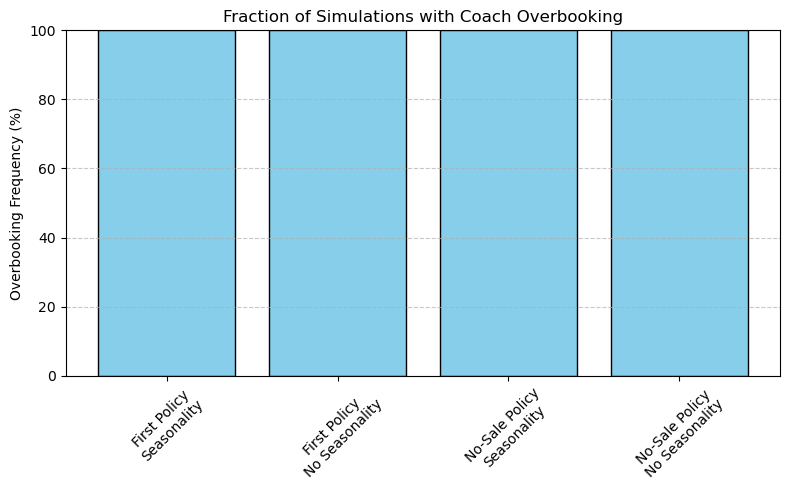

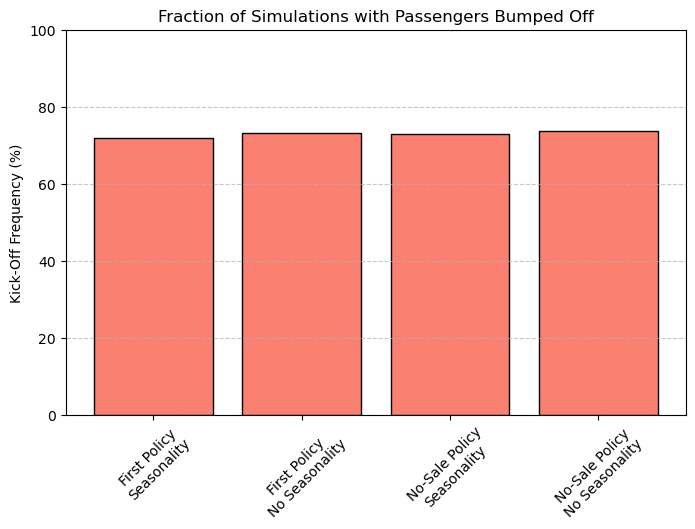

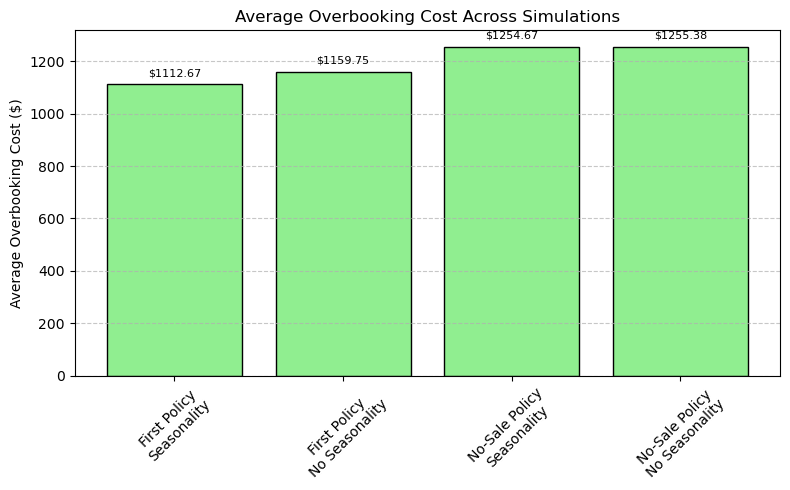

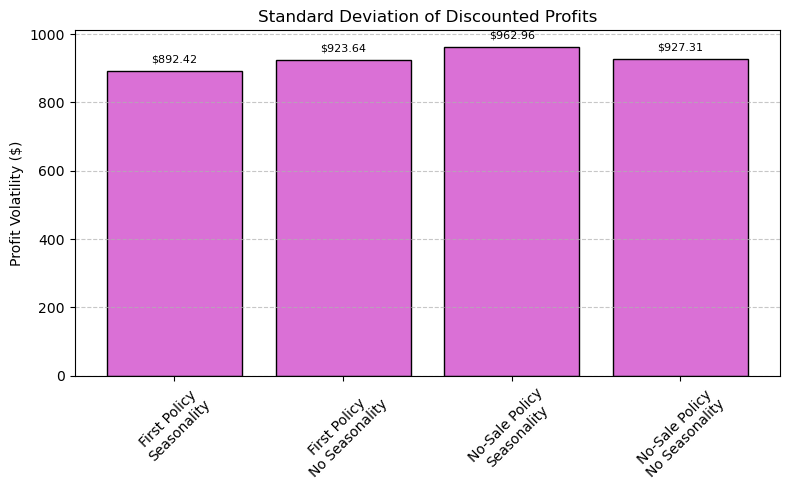

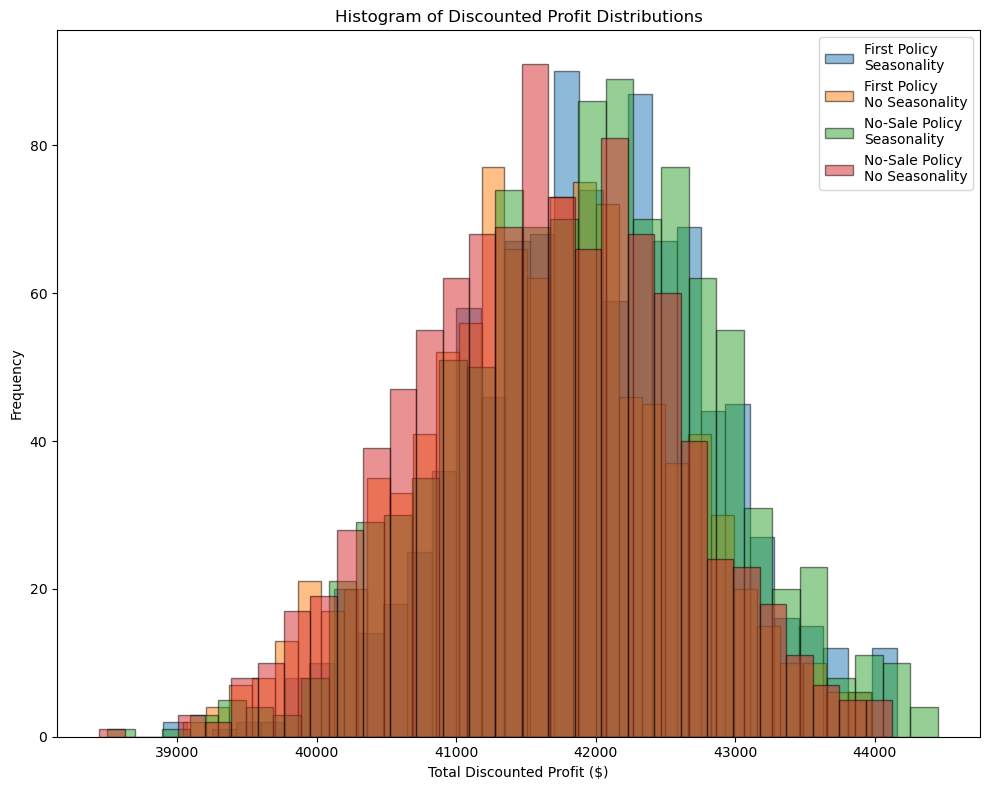


Policy: First Policy
Seasonality
  Overbooking Frequency: 100.0%
  Kick-Off Frequency: 71.9%
  Average Overbooking Cost: $1112.67
  Profit Volatility (Std Dev): $892.42
  Average Discounted Profit: $41949.90

Policy: First Policy
No Seasonality
  Overbooking Frequency: 100.0%
  Kick-Off Frequency: 73.2%
  Average Overbooking Cost: $1159.75
  Profit Volatility (Std Dev): $923.64
  Average Discounted Profit: $41614.76

Policy: No-Sale Policy
Seasonality
  Overbooking Frequency: 100.0%
  Kick-Off Frequency: 72.8%
  Average Overbooking Cost: $1254.67
  Profit Volatility (Std Dev): $962.96
  Average Discounted Profit: $41932.71

Policy: No-Sale Policy
No Seasonality
  Overbooking Frequency: 100.0%
  Kick-Off Frequency: 73.6%
  Average Overbooking Cost: $1255.38
  Profit Volatility (Std Dev): $927.31
  Average Discounted Profit: $41610.98


In [29]:

def compute_metrics(sim_results):
    """
    Computes key performance metrics from a list of simulation result dictionaries.
    Expects each simulation dictionary to include:
      - "final_coach", "final_fc", "discounted_profit",
      - "overbooked": tickets sold beyond 100,
      - "bumped_to_fc": number of passengers bumped to first-class,
      - "kicked_off": number of passengers kicked off.
    
    Returns a dictionary of metrics:
      - overbook_freq: fraction of runs with any overbooking (final_coach > COACH_SEATS).
      - bump_freq: fraction of runs where bumped_to_fc > 0.
      - kick_off_freq: fraction of runs where kicked_off > 0.
      - avg_overbooking_cost: average overbooking cost (computed from bumped_to_fc and kicked_off).
      - profit_vol: standard deviation of discounted profits.
      - avg_profit: mean discounted profit.
      - profits: array of discounted profits.
    """
    num_runs = len(sim_results)
    overbook_count = sum(1 for res in sim_results if res["overbooked"] > 0)
    bump_count = sum(1 for res in sim_results if res["bumped_to_fc"] > 0)
    kick_off_count = sum(1 for res in sim_results if res["kicked_off"] > 0)
    profits = np.array([res["discounted_profit"] for res in sim_results])
    
    # Calculate overbooking cost for each run:
    overbooking_costs = np.array([
        res["bumped_to_fc"] * bump_to_first_class_cost + res["kicked_off"] * bump_off_cost
        for res in sim_results
    ])
    
    metrics = {
        "overbook_freq": overbook_count / num_runs,
        "bump_freq": bump_count / num_runs,
        "kick_off_freq": kick_off_count / num_runs,
        "avg_overbooking_cost": np.mean(overbooking_costs),
        "profit_vol": np.std(profits),
        "avg_profit": np.mean(profits),
        "profits": profits
    }
    return metrics

# Assume we already have simulation results from the four scenarios:
# sim_first_season, sim_first_no_season, sim_no_sale_season, sim_no_sale_no_season

# For demonstration purposes, if you haven't run the simulations, you could imagine these
# lists are the outputs from your simulate_forward_policy() calls.
# For example:
# sim_first_season = simulate_forward_policy(dp_first_season, overbook_limit=10, use_seasonality=True, num_simulations=1000)
# ... and similarly for the other three.

# Compute metrics for each case:
metrics_first_season = compute_metrics(sim_first_season)
metrics_first_no_season = compute_metrics(sim_first_no_season)
metrics_no_sale_season = compute_metrics(sim_no_sale_season)
metrics_no_sale_no_season = compute_metrics(sim_no_sale_no_season)

# Organize the metrics in a dictionary for easier plotting:
policy_labels = ["First Policy\nSeasonality", "First Policy\nNo Seasonality",
                 "No-Sale Policy\nSeasonality", "No-Sale Policy\nNo Seasonality"]
all_metrics = [metrics_first_season, metrics_first_no_season,
               metrics_no_sale_season, metrics_no_sale_no_season]

# -----------------------------------
# Graph 1: Bar Chart for Overbooking Frequency
# -----------------------------------
overbook_freqs = [m["overbook_freq"] * 100 for m in all_metrics]  # convert to percentage
x = np.arange(len(policy_labels))
plt.figure(figsize=(8, 5))
bars = plt.bar(x, overbook_freqs, color='skyblue', edgecolor='black')
plt.xticks(x, policy_labels, rotation=45)
plt.ylabel("Overbooking Frequency (%)")
plt.title("Fraction of Simulations with Coach Overbooking")
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# -----------------------------------
# Graph 2: Bar Chart for Passenger Kick-Off Frequency
# -----------------------------------
kick_off_freqs = [m["kick_off_freq"] * 100 for m in all_metrics]  # percentage
plt.figure(figsize=(8, 5))
bars = plt.bar(x, kick_off_freqs, color='salmon', edgecolor='black')
plt.xticks(x, policy_labels, rotation=45)
plt.ylabel("Kick-Off Frequency (%)")
plt.title("Fraction of Simulations with Passengers Bumped Off")
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# -----------------------------------
# Graph 3: Bar Chart for Average Overbooking Cost
# -----------------------------------
avg_overbooking_costs = [m["avg_overbooking_cost"] for m in all_metrics]
plt.figure(figsize=(8, 5))
bars = plt.bar(x, avg_overbooking_costs, color='lightgreen', edgecolor='black')
plt.xticks(x, policy_labels, rotation=45)
plt.ylabel("Average Overbooking Cost ($)")
plt.title("Average Overbooking Cost Across Simulations")
plt.grid(axis='y', linestyle='--', alpha=0.7)
# Add data labels:
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + (0.02 * height), f"${height:.2f}", ha='center', va='bottom', fontsize=8)
plt.tight_layout()
plt.show()

# -----------------------------------
# Graph 4: Bar Chart for Profit Volatility (Std. Dev.)
# -----------------------------------
profit_vols = [m["profit_vol"] for m in all_metrics]
plt.figure(figsize=(8, 5))
bars = plt.bar(x, profit_vols, color='orchid', edgecolor='black')
plt.xticks(x, policy_labels, rotation=45)
plt.ylabel("Profit Volatility ($)")
plt.title("Standard Deviation of Discounted Profits")
plt.grid(axis='y', linestyle='--', alpha=0.7)
# Add data labels:
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + (0.02 * height), f"${height:.2f}", ha='center', va='bottom', fontsize=8)
plt.tight_layout()
plt.show()

# -----------------------------------
# Graph 5: Histogram of Discounted Profit Distributions
# -----------------------------------
plt.figure(figsize=(10, 8))
bins = 30
for i, m in enumerate(all_metrics):
    plt.hist(m["profits"], bins=bins, alpha=0.5, label=policy_labels[i], edgecolor='black')
plt.xlabel("Total Discounted Profit ($)")
plt.ylabel("Frequency")
plt.title("Histogram of Discounted Profit Distributions")
plt.legend()
plt.tight_layout()
plt.show()

# -----------------------------------
# Print a Summary of the Metrics for Each Policy
# -----------------------------------
for label, m in zip(policy_labels, all_metrics):
    print(f"\nPolicy: {label}")
    print(f"  Overbooking Frequency: {m['overbook_freq']*100:.1f}%")
    print(f"  Kick-Off Frequency: {m['kick_off_freq']*100:.1f}%")
    print(f"  Average Overbooking Cost: ${m['avg_overbooking_cost']:.2f}")
    print(f"  Profit Volatility (Std Dev): ${m['profit_vol']:.2f}")
    print(f"  Average Discounted Profit: ${m['avg_profit']:.2f}")


In [30]:
# -----------------------------------
# Print a Summary of the Metrics for Each Policy
# -----------------------------------
for label, m in zip(policy_labels, all_metrics):
    print(f"\nPolicy: {label}")
    print(f"  Overbooking Frequency: {m['overbook_freq']*100:.1f}%")
    print(f"  Kick-Off Frequency: {m['kick_off_freq']*100:.1f}%")
    print(f"  Average Overbooking Cost: ${m['avg_overbooking_cost']:.2f}")
    print(f"  Profit Volatility (Std Dev): ${m['profit_vol']:.2f}")
    print(f"  Average Discounted Profit: ${m['avg_profit']:.2f}")


Policy: First Policy
Seasonality
  Overbooking Frequency: 100.0%
  Kick-Off Frequency: 71.9%
  Average Overbooking Cost: $1112.67
  Profit Volatility (Std Dev): $892.42
  Average Discounted Profit: $41949.90

Policy: First Policy
No Seasonality
  Overbooking Frequency: 100.0%
  Kick-Off Frequency: 73.2%
  Average Overbooking Cost: $1159.75
  Profit Volatility (Std Dev): $923.64
  Average Discounted Profit: $41614.76

Policy: No-Sale Policy
Seasonality
  Overbooking Frequency: 100.0%
  Kick-Off Frequency: 72.8%
  Average Overbooking Cost: $1254.67
  Profit Volatility (Std Dev): $962.96
  Average Discounted Profit: $41932.71

Policy: No-Sale Policy
No Seasonality
  Overbooking Frequency: 100.0%
  Kick-Off Frequency: 73.6%
  Average Overbooking Cost: $1255.38
  Profit Volatility (Std Dev): $927.31
  Average Discounted Profit: $41610.98


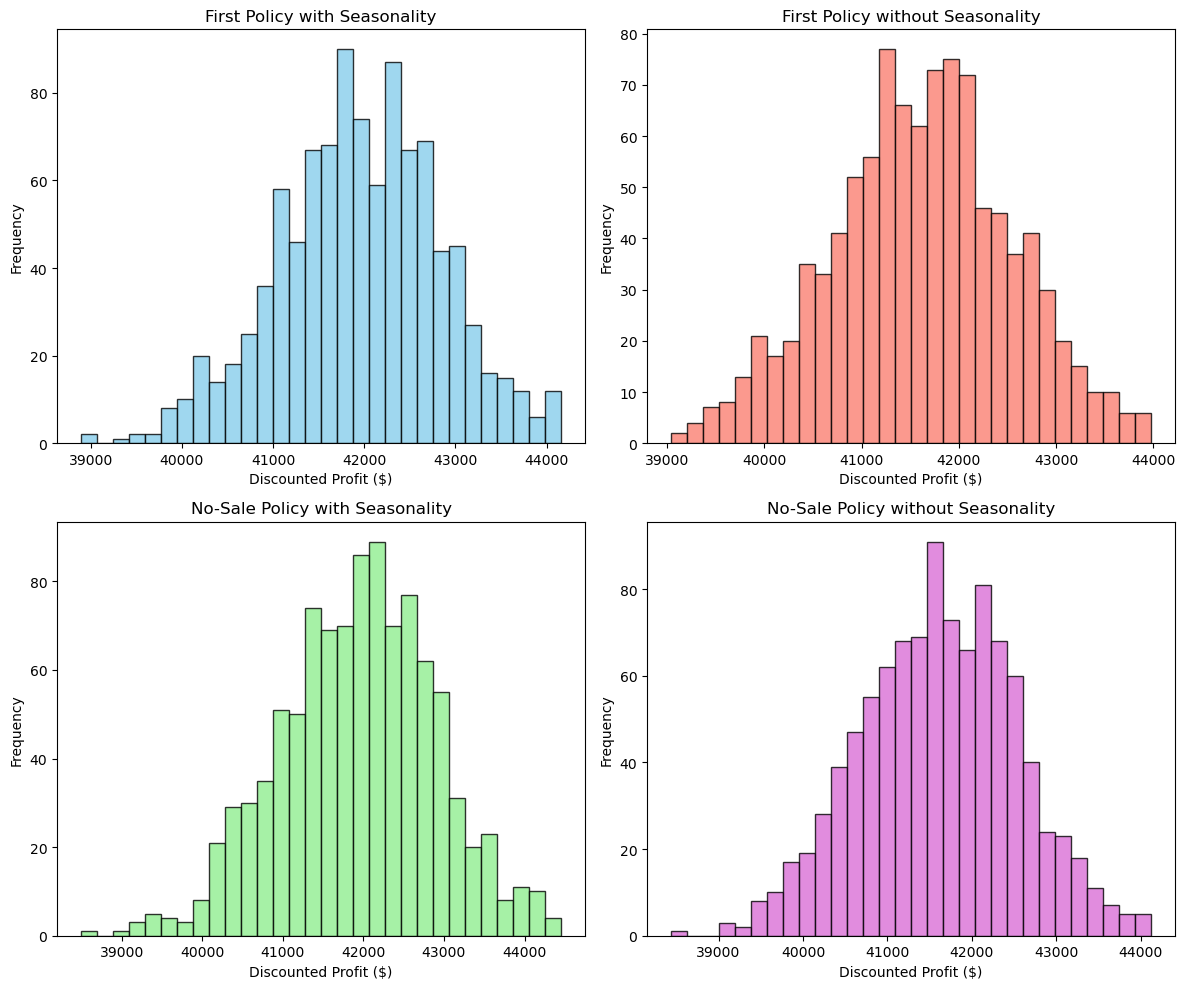

In [31]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))

# First Policy with Seasonality
plt.subplot(2, 2, 1)
plt.hist(metrics_first_season["profits"], bins=30, color='skyblue', edgecolor='black', alpha=0.8)
plt.title("First Policy with Seasonality")
plt.xlabel("Discounted Profit ($)")
plt.ylabel("Frequency")

# First Policy without Seasonality
plt.subplot(2, 2, 2)
plt.hist(metrics_first_no_season["profits"], bins=30, color='salmon', edgecolor='black', alpha=0.8)
plt.title("First Policy without Seasonality")
plt.xlabel("Discounted Profit ($)")
plt.ylabel("Frequency")

# No-Sale Policy with Seasonality
plt.subplot(2, 2, 3)
plt.hist(metrics_no_sale_season["profits"], bins=30, color='lightgreen', edgecolor='black', alpha=0.8)
plt.title("No-Sale Policy with Seasonality")
plt.xlabel("Discounted Profit ($)")
plt.ylabel("Frequency")

# No-Sale Policy without Seasonality
plt.subplot(2, 2, 4)
plt.hist(metrics_no_sale_no_season["profits"], bins=30, color='orchid', edgecolor='black', alpha=0.8)
plt.title("No-Sale Policy without Seasonality")
plt.xlabel("Discounted Profit ($)")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()


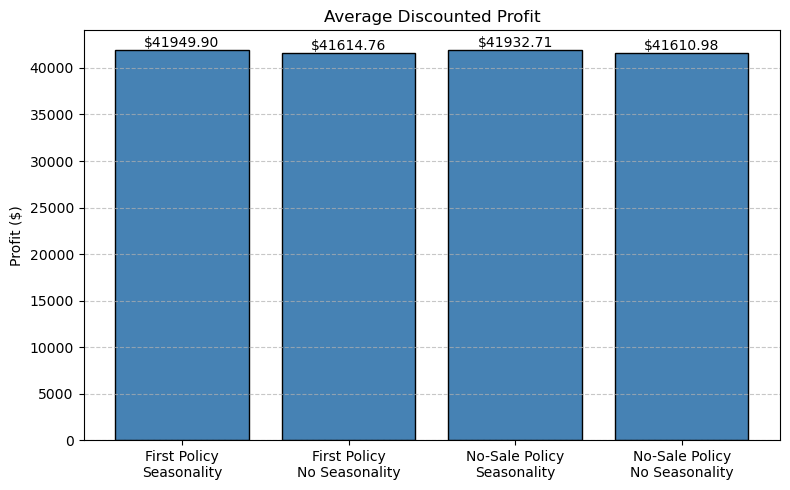

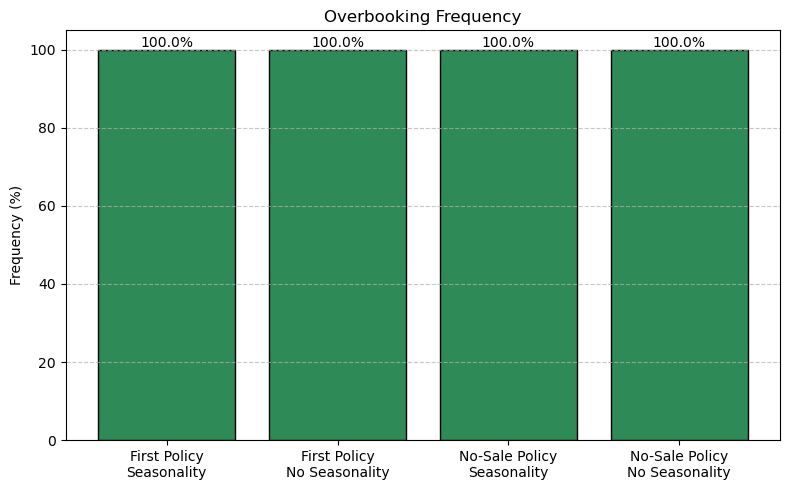

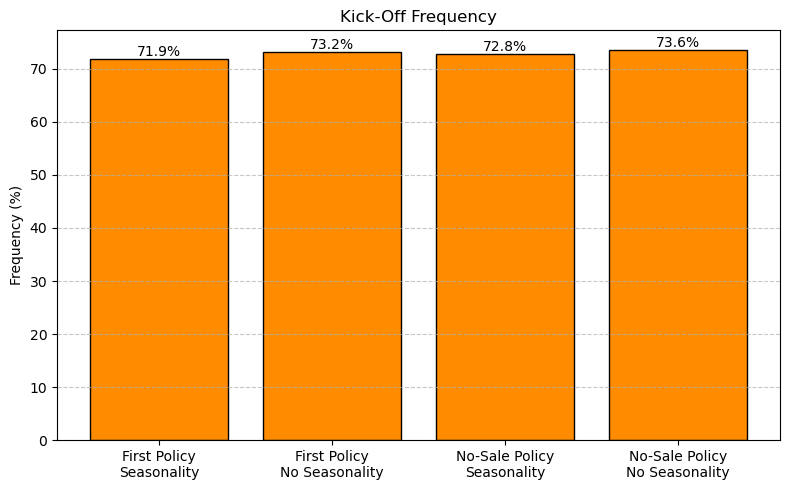

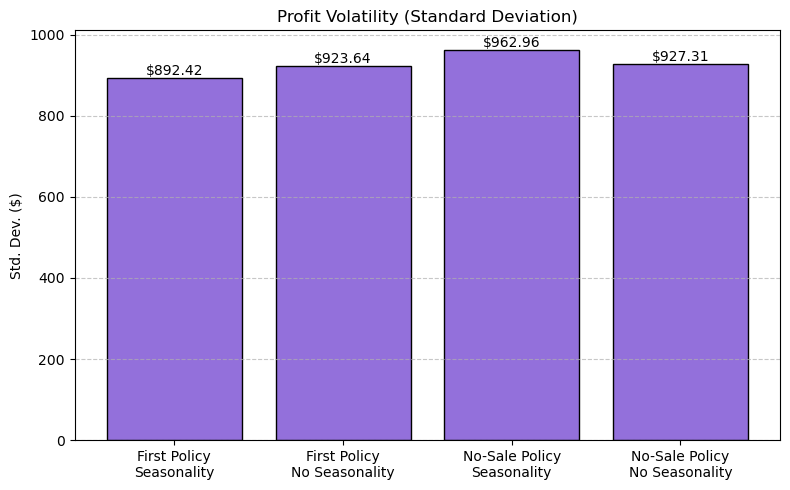

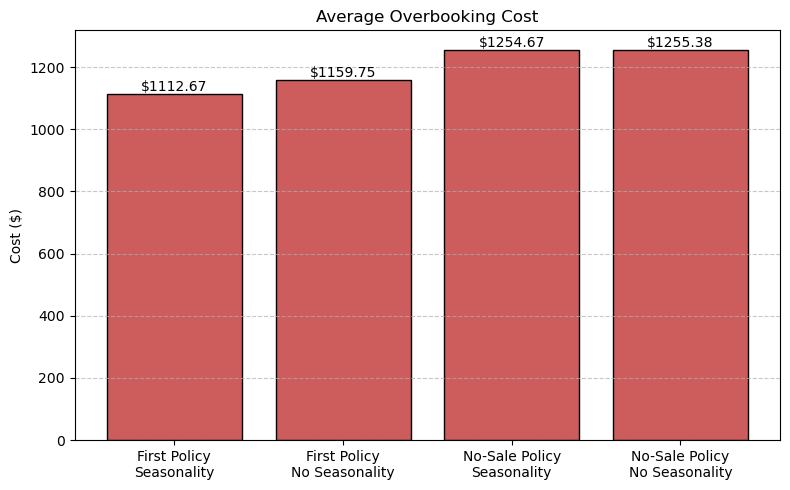

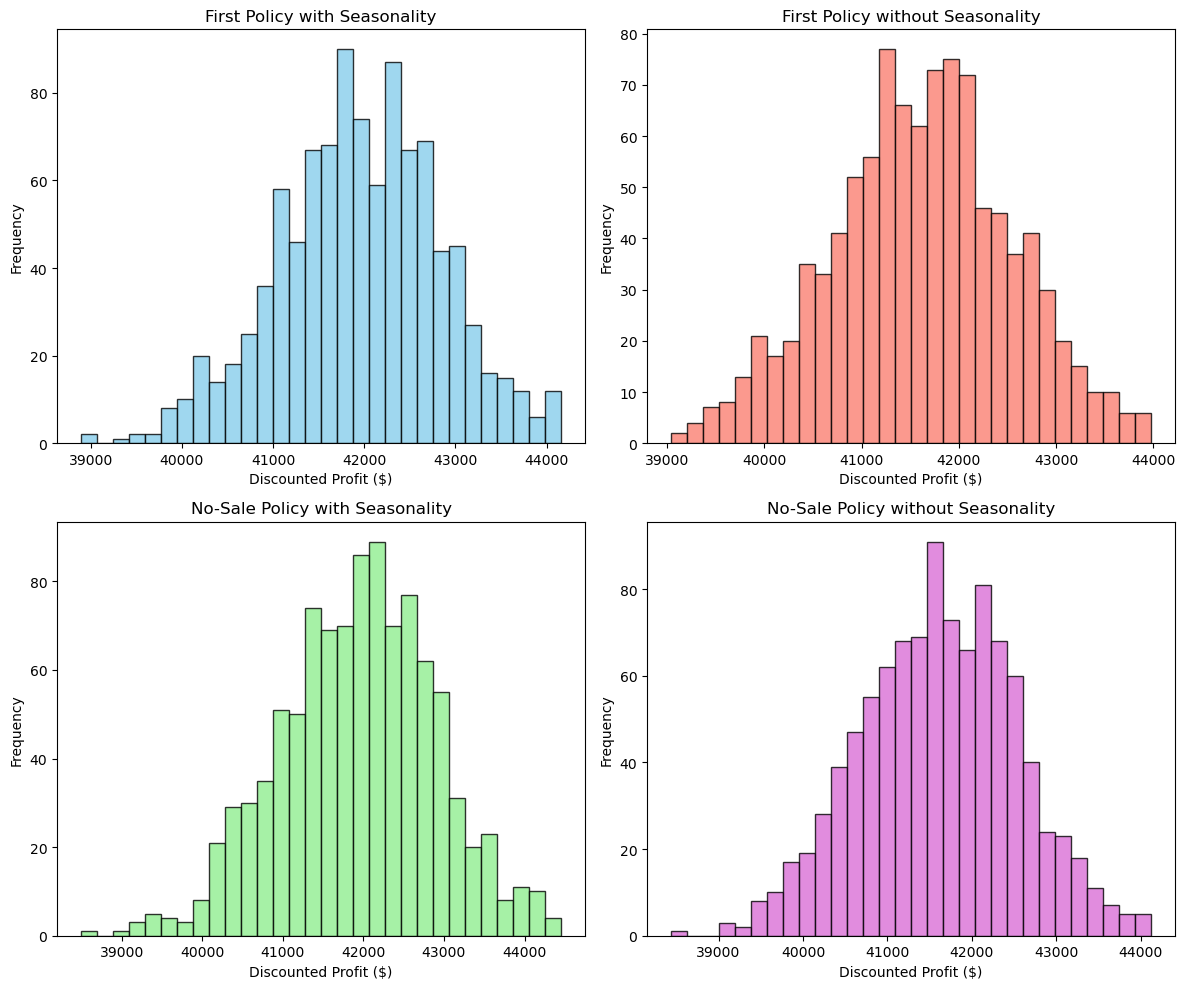

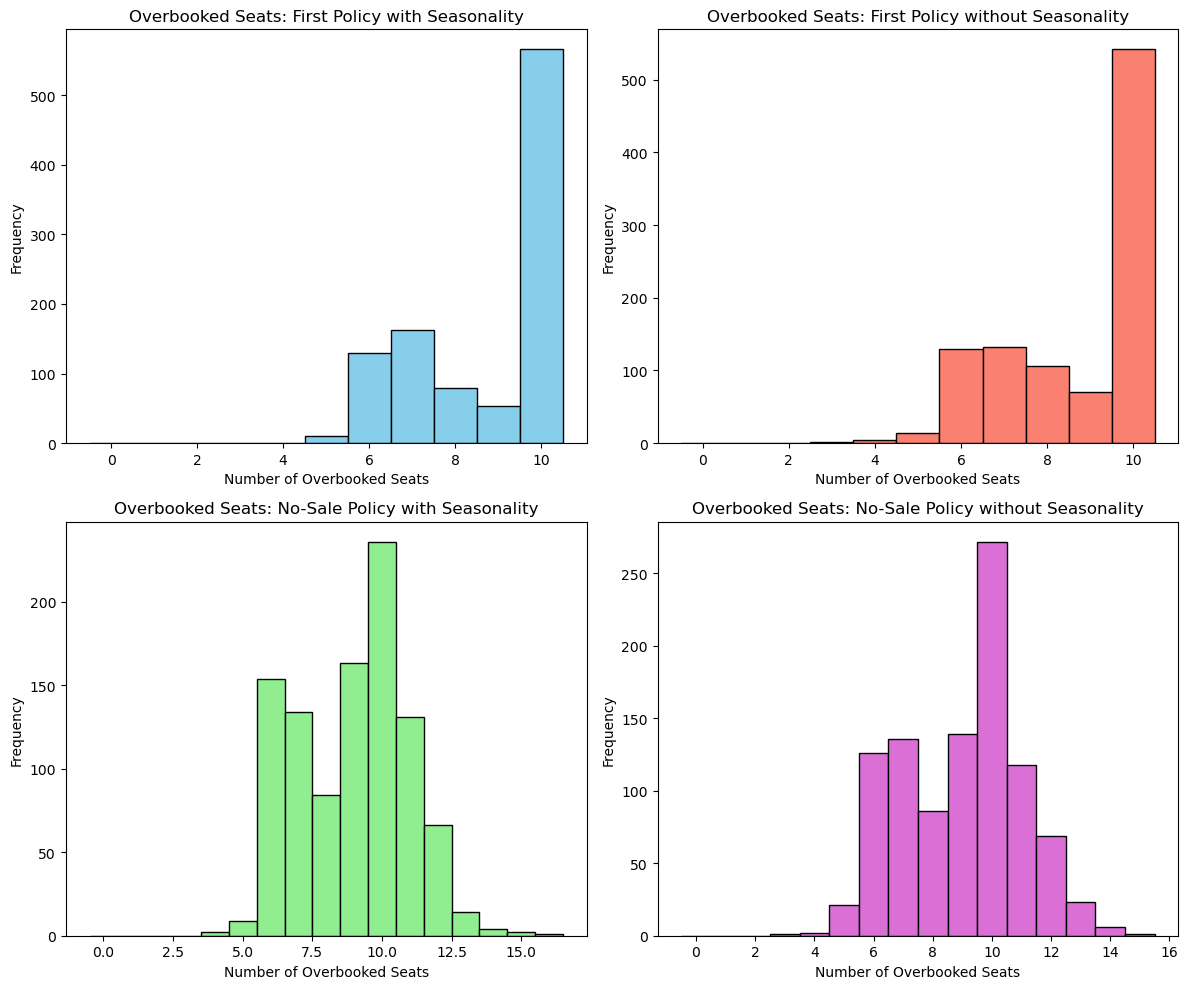

In [32]:
import matplotlib.pyplot as plt
import numpy as np

# --------------------------
# Define Policy Labels and Organize Metrics
# --------------------------
policy_labels = ["First Policy\nSeasonality", "First Policy\nNo Seasonality",
                 "No-Sale Policy\nSeasonality", "No-Sale Policy\nNo Seasonality"]
all_metrics = [metrics_first_season, metrics_first_no_season, 
               metrics_no_sale_season, metrics_no_sale_no_season]

# --------------------------
# Bar Graphs
# --------------------------

# 1. Bar Graph for Average Discounted Profit
avg_profits = [m["avg_profit"] for m in all_metrics]
plt.figure(figsize=(8, 5))
bars = plt.bar(policy_labels, avg_profits, color='steelblue', edgecolor='black')
plt.title("Average Discounted Profit")
plt.ylabel("Profit ($)")
plt.grid(axis='y', linestyle='--', alpha=0.7)
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height, f"${height:.2f}",
             ha='center', va='bottom', fontsize=10)
plt.tight_layout()
plt.show()

# 2. Bar Graph for Overbooking Frequency (%)
overbook_freqs = [m["overbook_freq"] * 100 for m in all_metrics]
plt.figure(figsize=(8, 5))
bars = plt.bar(policy_labels, overbook_freqs, color='seagreen', edgecolor='black')
plt.title("Overbooking Frequency")
plt.ylabel("Frequency (%)")
plt.grid(axis='y', linestyle='--', alpha=0.7)
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height, f"{height:.1f}%",
             ha='center', va='bottom', fontsize=10)
plt.tight_layout()
plt.show()

# 3. Bar Graph for Kick-Off Frequency (%)
kick_off_freqs = [m["kick_off_freq"] * 100 for m in all_metrics]
plt.figure(figsize=(8, 5))
bars = plt.bar(policy_labels, kick_off_freqs, color='darkorange', edgecolor='black')
plt.title("Kick-Off Frequency")
plt.ylabel("Frequency (%)")
plt.grid(axis='y', linestyle='--', alpha=0.7)
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height, f"{height:.1f}%",
             ha='center', va='bottom', fontsize=10)
plt.tight_layout()
plt.show()

# 4. Bar Graph for Profit Volatility (Std. Dev.)
profit_vols = [m["profit_vol"] for m in all_metrics]
plt.figure(figsize=(8, 5))
bars = plt.bar(policy_labels, profit_vols, color='mediumpurple', edgecolor='black')
plt.title("Profit Volatility (Standard Deviation)")
plt.ylabel("Std. Dev. ($)")
plt.grid(axis='y', linestyle='--', alpha=0.7)
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height, f"${height:.2f}",
             ha='center', va='bottom', fontsize=10)
plt.tight_layout()
plt.show()

# 5. Bar Graph for Average Overbooking Cost
avg_overbooking_costs = [m["avg_overbooking_cost"] for m in all_metrics]
plt.figure(figsize=(8, 5))
bars = plt.bar(policy_labels, avg_overbooking_costs, color='indianred', edgecolor='black')
plt.title("Average Overbooking Cost")
plt.ylabel("Cost ($)")
plt.grid(axis='y', linestyle='--', alpha=0.7)
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height, f"${height:.2f}",
             ha='center', va='bottom', fontsize=10)
plt.tight_layout()
plt.show()

# --------------------------
# Histograms
# --------------------------

# 1. Histogram of Discounted Profit Distributions (Individual Plots)
plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
plt.hist(metrics_first_season["profits"], bins=30, color='skyblue', edgecolor='black', alpha=0.8)
plt.title("First Policy with Seasonality")
plt.xlabel("Discounted Profit ($)")
plt.ylabel("Frequency")

plt.subplot(2, 2, 2)
plt.hist(metrics_first_no_season["profits"], bins=30, color='salmon', edgecolor='black', alpha=0.8)
plt.title("First Policy without Seasonality")
plt.xlabel("Discounted Profit ($)")
plt.ylabel("Frequency")

plt.subplot(2, 2, 3)
plt.hist(metrics_no_sale_season["profits"], bins=30, color='lightgreen', edgecolor='black', alpha=0.8)
plt.title("No-Sale Policy with Seasonality")
plt.xlabel("Discounted Profit ($)")
plt.ylabel("Frequency")

plt.subplot(2, 2, 4)
plt.hist(metrics_no_sale_no_season["profits"], bins=30, color='orchid', edgecolor='black', alpha=0.8)
plt.title("No-Sale Policy without Seasonality")
plt.xlabel("Discounted Profit ($)")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

# 2. Histogram of Frequency Distribution of Overbooked Seats
# We'll compute the number of overbooked seats (final_coach - COACH_SEATS) from the simulation results.

def get_overbooked(sim_results):
    return [max(0, res["final_coach"] - COACH_SEATS) for res in sim_results]

overbook_first_season = get_overbooked(sim_first_season)
overbook_first_no_season = get_overbooked(sim_first_no_season)
overbook_no_sale_season = get_overbooked(sim_no_sale_season)
overbook_no_sale_no_season = get_overbooked(sim_no_sale_no_season)

plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
plt.hist(overbook_first_season, bins=range(0, max(overbook_first_season)+2), color='skyblue', 
         edgecolor='black', align='left')
plt.title("Overbooked Seats: First Policy with Seasonality")
plt.xlabel("Number of Overbooked Seats")
plt.ylabel("Frequency")

plt.subplot(2, 2, 2)
plt.hist(overbook_first_no_season, bins=range(0, max(overbook_first_no_season)+2), color='salmon', 
         edgecolor='black', align='left')
plt.title("Overbooked Seats: First Policy without Seasonality")
plt.xlabel("Number of Overbooked Seats")
plt.ylabel("Frequency")

plt.subplot(2, 2, 3)
plt.hist(overbook_no_sale_season, bins=range(0, max(overbook_no_sale_season)+2), color='lightgreen', 
         edgecolor='black', align='left')
plt.title("Overbooked Seats: No-Sale Policy with Seasonality")
plt.xlabel("Number of Overbooked Seats")
plt.ylabel("Frequency")

plt.subplot(2, 2, 4)
plt.hist(overbook_no_sale_no_season, bins=range(0, max(overbook_no_sale_no_season)+2), color='orchid', 
         edgecolor='black', align='left')
plt.title("Overbooked Seats: No-Sale Policy without Seasonality")
plt.xlabel("Number of Overbooked Seats")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()
